In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, RobustScaler

In [53]:
jokes = pd.read_csv('../Data/processed_jokes.csv', delimiter=',',index_col=0)
jokes.head()

,Text,CharCount,WordCount,AverageRating,StdDev,Popularity
JokeID,,,,,,
1,"A man visits the doctor. The doctor says, ""I h...",165,30,NaN,NaN,0
2,This couple had an excellent relationship goin...,375,71,NaN,NaN,0
3,Q. What's 200 feet long and has 4 teeth? A. Th...,85,18,NaN,NaN,0
4,Q. What's the difference between a man and a t...,108,21,NaN,NaN,0
5,Q. What's O. J. Simpson's web address? A. Slas...,88,14,-2.034618,5.423289,566


**Simple Content based Filtering**

In [54]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(jokes['Text'].fillna(''))
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [55]:
def get_recommendations(joke_id, sim_matrix, top_n=5):
    if joke_id < 1 or joke_id > 150:
        print("Invalid Joke Id")
        return

    idx = jokes.index.get_loc(joke_id)
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1],
                        reverse=True)[1:top_n + 1]

    indices = [i[0] for i in sim_scores]
    return jokes.iloc[indices][['Text']]
recc = get_recommendations(40, cosine_sim)
recc

,Text
JokeID,
90,Q: How many programmers does it take to change...
58,How many teddy bears does it take to change a ...
74,Q: How many stalkers does it take to change a ...
32,A man arrives at the gates of heaven. St. Pete...
86,A neutron walks into a bar and orders a drink....


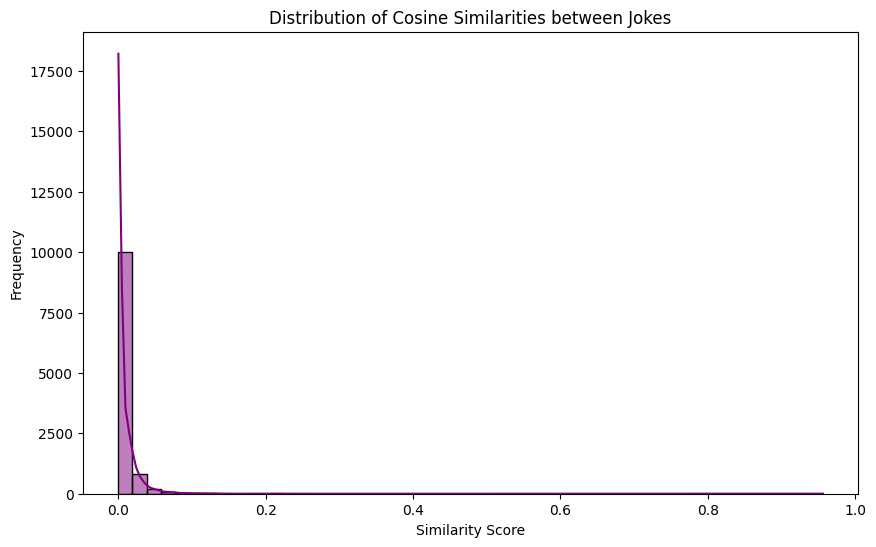

In [56]:
sim_values = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

plt.figure(figsize=(10, 6))
sns.histplot(sim_values,bins=50, kde=True, color='purple')
plt.title('Distribution of Cosine Similarities between Jokes')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

**Content based filtering with LSA**

In [57]:
random_state = 123

Components: 2 | Explained Variance: 0.0206
Components: 7 | Explained Variance: 0.0737
Components: 12 | Explained Variance: 0.1170
Components: 17 | Explained Variance: 0.1571
Components: 22 | Explained Variance: 0.1958
Components: 27 | Explained Variance: 0.2332
Components: 32 | Explained Variance: 0.2689
Components: 37 | Explained Variance: 0.3060
Components: 42 | Explained Variance: 0.3409
Components: 47 | Explained Variance: 0.3751
Components: 52 | Explained Variance: 0.4099
Components: 57 | Explained Variance: 0.4444
Components: 62 | Explained Variance: 0.4776
Components: 67 | Explained Variance: 0.5116
Components: 72 | Explained Variance: 0.5448
Components: 77 | Explained Variance: 0.5781
Components: 82 | Explained Variance: 0.6106
Components: 87 | Explained Variance: 0.6427
Components: 92 | Explained Variance: 0.6748
Components: 97 | Explained Variance: 0.7072
Components: 102 | Explained Variance: 0.7379
Components: 107 | Explained Variance: 0.7691
Components: 112 | Explained Vari

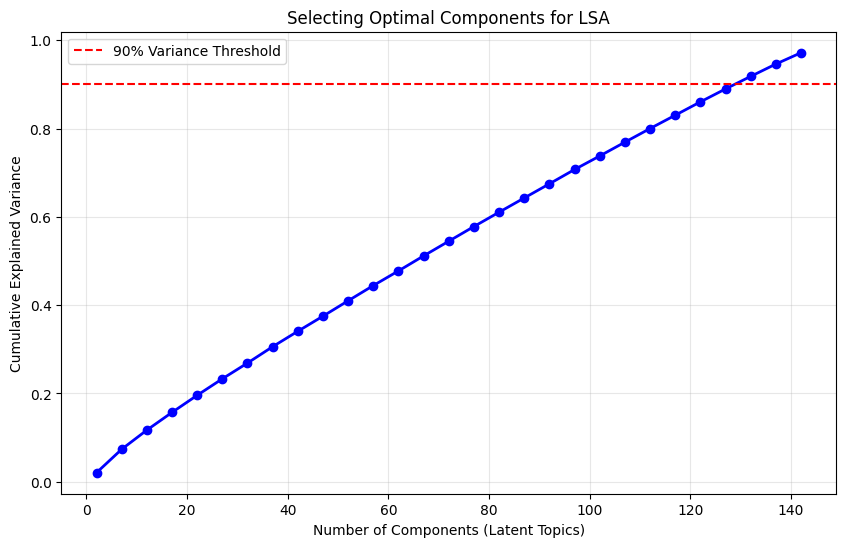

In [58]:
def experiment_lsa_components(tfidf_matrix, components_range):
    explained_variances = []

    for n in components_range:
        svd = TruncatedSVD(n_components=n, random_state=random_state)
        svd.fit(tfidf_matrix)
        total_variance = svd.explained_variance_ratio_.sum()
        explained_variances.append(total_variance)
        print(f"Components: {n} | Explained Variance: {total_variance:.4f}")

    return explained_variances

n_comp_list = np.arange(2,145,step=5)
variances = experiment_lsa_components(tfidf_matrix, n_comp_list)

plt.figure(figsize=(10, 6))
plt.plot(n_comp_list, variances, 'bo-', linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')

plt.title('Selecting Optimal Components for LSA')
plt.xlabel('Number of Components (Latent Topics)')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The analysis of the cumulative explained variance revealed a near-linear growth, indicating a high degree of semantic diversity across the joke corpus. We selected 110 componets to achieve optimal balance between dimensionality reduction and information preservation.This configuration captures 80% of the total variance.

In [59]:
svd_final = TruncatedSVD(n_components=110, random_state=random_state)
lsa_matrix_final = svd_final.fit_transform(tfidf_matrix)
cosine_sim_lsa = cosine_similarity(lsa_matrix_final)

In [60]:
test_id = 10 
print(jokes.iloc[test_id,0])
print("--- Text Matching (TF-IDF - only words) ---")
print(get_recommendations(test_id, cosine_sim)) 

print("\n--- Semantic similarity (LSA 110 components) ---")
print(get_recommendations(test_id, cosine_sim_lsa))

Q. What do a hurricane, a tornado, and a redneck divorce all have in common? A. Someone's going to lose a trailer...
--- Text Matching (TF-IDF - only words) ---
                                                     Text
JokeID                                                   
7       How many feminists does it take to screw in a ...
37      A Jewish young man was seeing a psychiatrist f...
90      Q: How many programmers does it take to change...
17      How many men does it take to screw in a light ...
6       Bill and Hillary Clinton are on a trip back to...

--- Semantic similarity (LSA 110 components) ---
                                                     Text
JokeID                                                   
7       How many feminists does it take to screw in a ...
37      A Jewish young man was seeing a psychiatrist f...
43      Arnold Schwarzenegger and Sylvester Stallone a...
104     As a pre-med student, I had to take a difficul...
6       Bill and Hillary Clinton ar

**Collaborative filtering experiments**

In [6]:
random_state = 123
ratings = pd.read_csv('../Data/processed_ratings.csv',
                      delimiter=',',
                      header=None)
ratings_matrix = ratings.iloc[:,1:]
ratings_raw = ratings_matrix.replace(99, np.nan).values
mask = ~np.isnan(ratings_raw)

**Split the ratings to test model more accurately**

In [24]:
nonzero_indices = np.argwhere(~np.isnan(ratings_raw))
train_idx, test_idx = train_test_split(nonzero_indices, test_size=0.2, random_state=random_state)
train_ratings = ratings_raw.copy()
for row, col in test_idx:
    train_ratings[row, col] = np.nan

In [23]:
def calculate_rmse_at_indices(predicted_matrix, original_matrix, indices):
    actual = []
    predicted = []
    for row, col in indices:
        actual.append(original_matrix[row, col])
        predicted.append(predicted_matrix[row, col])
    return np.sqrt(mean_squared_error(actual, predicted))

In [27]:
def create_svd_pipeline_with_mean_imputing(n_components):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean', keep_empty_features=True)),
        ('svd', TruncatedSVD(n_components=n_components, random_state=random_state))
    ])

Components:   2 | Train RMSE: 4.3789 | Test RMSE: 4.4878
Components:   5 | Train RMSE: 4.0019 | Test RMSE: 4.3976
Components:  10 | Train RMSE: 3.6358 | Test RMSE: 4.4411
Components:  20 | Train RMSE: 3.1829 | Test RMSE: 4.5115
Components:  30 | Train RMSE: 2.8822 | Test RMSE: 4.5734
Components:  40 | Train RMSE: 2.6170 | Test RMSE: 4.6344
Components:  50 | Train RMSE: 2.3642 | Test RMSE: 4.6930
Components:  75 | Train RMSE: 1.7621 | Test RMSE: 4.8274
Components: 100 | Train RMSE: 1.1583 | Test RMSE: 4.9484
Components: 105 | Train RMSE: 1.0241 | Test RMSE: 4.9691
Components: 110 | Train RMSE: 0.8916 | Test RMSE: 4.9877


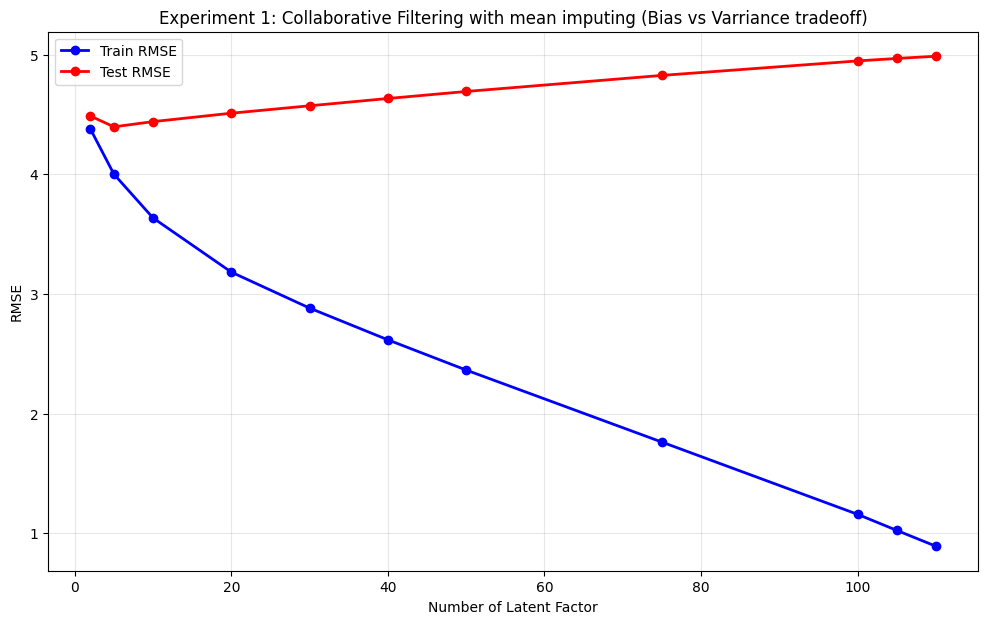

In [29]:
components_list = [2, 5, 10, 20, 30, 40, 50, 75, 100, 105, 110]
train_rmse_results = []
test_rmse_results = []

for n in components_list:
    pipe = create_svd_pipeline_with_mean_imputing(n)
    user_features = pipe.fit_transform(train_ratings)
    vt = pipe.named_steps['svd'].components_
    
    predicted_matrix = np.dot(user_features, vt)
    
    train_rmse = calculate_rmse_at_indices(predicted_matrix, ratings_raw, train_idx)
    train_rmse_results.append(train_rmse)
    
    test_rmse = calculate_rmse_at_indices(predicted_matrix, ratings_raw, test_idx)
    test_rmse_results.append(test_rmse)
    
    print(f"Components: {n:3} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(components_list, train_rmse_results, 'bo-', label='Train RMSE', linewidth=2)
plt.plot(components_list, test_rmse_results, 'ro-', label='Test RMSE', linewidth=2)

plt.title('Experiment 1: Collaborative Filtering with mean imputing (Bias vs Varriance tradeoff)')
plt.xlabel('Number of Latent Factor')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<summary>
The plot illustrates the Bias-Variance Tradeoff. As the number of latent factors increases the Train RMSE decreases steadily. This shows the model's increasing capacity to memorize the training data. However, the Test RMSE begins to rise almost immediately after 5 components which represents the optimal complexity for this baseline. The diverging curves are a  sign of overfitting. This behavior is exacerbated by the "Mean Imputing" strategy, which forces the SVD to reconstruct global averages that do not account for individual user bias.
</summary>

**Truncated SVD with mean centering**

In [30]:
def center_user_ratings(X):
    user_means = np.nanmean(X, axis=1).reshape(-1, 1)
    return X - user_means

In [36]:
def create_svd_pipeline_with_mean_centring(n_components):
    return Pipeline([
        ('user_centering', FunctionTransformer(center_user_ratings)),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True)),
        ('svd', TruncatedSVD(n_components=n_components, random_state=random_state))
    ])

Components:   2 | Train RMSE: 3.8857 | Test RMSE: 4.2872
Components:   5 | Train RMSE: 3.6352 | Test RMSE: 4.3756
Components:  10 | Train RMSE: 3.2803 | Test RMSE: 4.3496
Components:  20 | Train RMSE: 2.9041 | Test RMSE: 4.3489
Components:  30 | Train RMSE: 2.6365 | Test RMSE: 4.3745
Components:  40 | Train RMSE: 2.3923 | Test RMSE: 4.3961
Components:  50 | Train RMSE: 2.1612 | Test RMSE: 4.4135
Components:  75 | Train RMSE: 1.6040 | Test RMSE: 4.4525
Components: 100 | Train RMSE: 1.0364 | Test RMSE: 4.4798
Components: 105 | Train RMSE: 0.9112 | Test RMSE: 4.4833
Components: 110 | Train RMSE: 0.7910 | Test RMSE: 4.4895


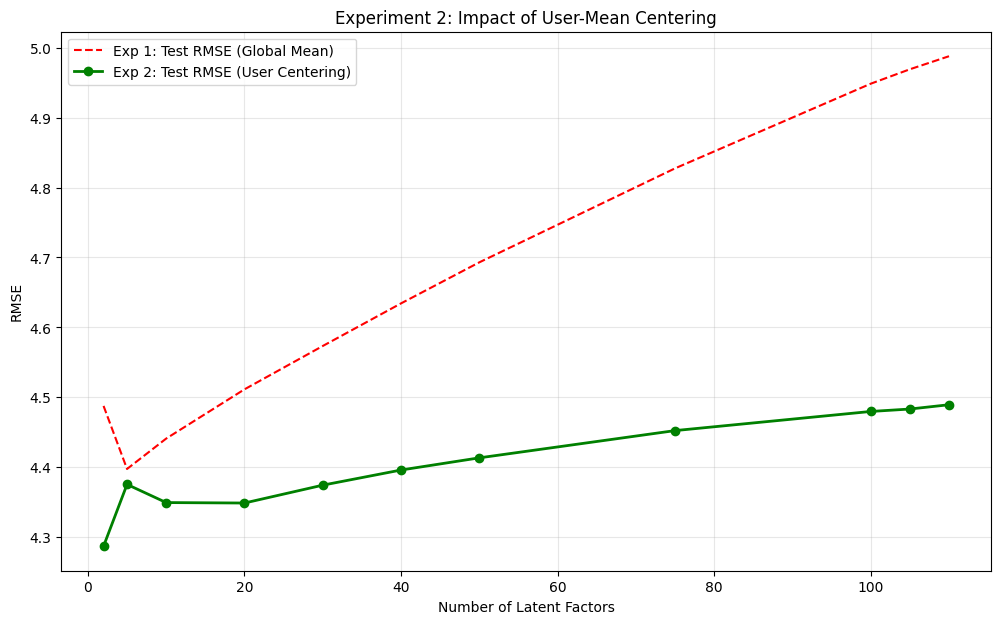

In [40]:
train_rmse_centered = []
test_rmse_centered = []
user_means = np.nanmean(train_ratings, axis=1).reshape(-1, 1)
for n in components_list:
    pipe = create_svd_pipeline_with_mean_centring(n)
    user_features = pipe.fit_transform(train_ratings)
    vt = pipe.named_steps['svd'].components_
    predicted_centered = np.dot(user_features, vt)

    predicted_final = predicted_centered + user_means
    
    train_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, train_idx)
    test_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, test_idx)
    
    train_rmse_centered.append(train_rmse)
    test_rmse_centered.append(test_rmse)
    print(f"Components: {n:3} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(components_list, test_rmse_results, 'r--', label='Exp 1: Test RMSE (Global Mean)')
plt.plot(components_list, test_rmse_centered, 'go-', label='Exp 2: Test RMSE (User Centering)', linewidth=2)

plt.title('Experiment 2: Impact of User-Mean Centering')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../images/experiment_2.png')
plt.show()

<summary>
User-Mean Centering shows an improvement over the prevous experiment. By subtracting each user's average rating before applying SVD, we successfully neutralized individual rating biases (optimism/pessimism).

The Test RMSE dropped significantly across all numbers of latent factors. Even at high complexity (110 components). Experiment 2 outperformed the best result of Experiment 1 by approximately 0.5 points.

While Experiment 1 showed a sharp near-linear increase in Test RMSE the error curve for Experiment 2 is much flatter. This suggests that the latent factors discovered after centering are more representative of actual communal humor patterns.

The model achieves its best performance with a very small number of components (n=2, RMSE = 4.2872). This confirms that a few primary dimensions explain a large portion of the variance in the Jester dataset.
</summary>

**Adding Scaling**

In [41]:
def create_svd_pipeline_scaling(n_components):
    return Pipeline([
        ('user_centering', FunctionTransformer(center_user_ratings)),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True)),
        ('scaler', StandardScaler()),
        ('svd', TruncatedSVD(n_components=n_components, random_state=42))
    ])

Components:   2 | Train RMSE: 4.0549 | Test RMSE: 4.2747
Components:   5 | Train RMSE: 3.8334 | Test RMSE: 4.1768
Components:  10 | Train RMSE: 3.6479 | Test RMSE: 4.1318
Components:  20 | Train RMSE: 3.4087 | Test RMSE: 4.1358
Components:  30 | Train RMSE: 3.1645 | Test RMSE: 4.1803
Components:  40 | Train RMSE: 2.9569 | Test RMSE: 4.2158
Components:  50 | Train RMSE: 2.7392 | Test RMSE: 4.2552
Components:  75 | Train RMSE: 2.1259 | Test RMSE: 4.3666
Components: 100 | Train RMSE: 1.4824 | Test RMSE: 4.4369
Components: 105 | Train RMSE: 1.3253 | Test RMSE: 4.4437
Components: 110 | Train RMSE: 1.1398 | Test RMSE: 4.4590


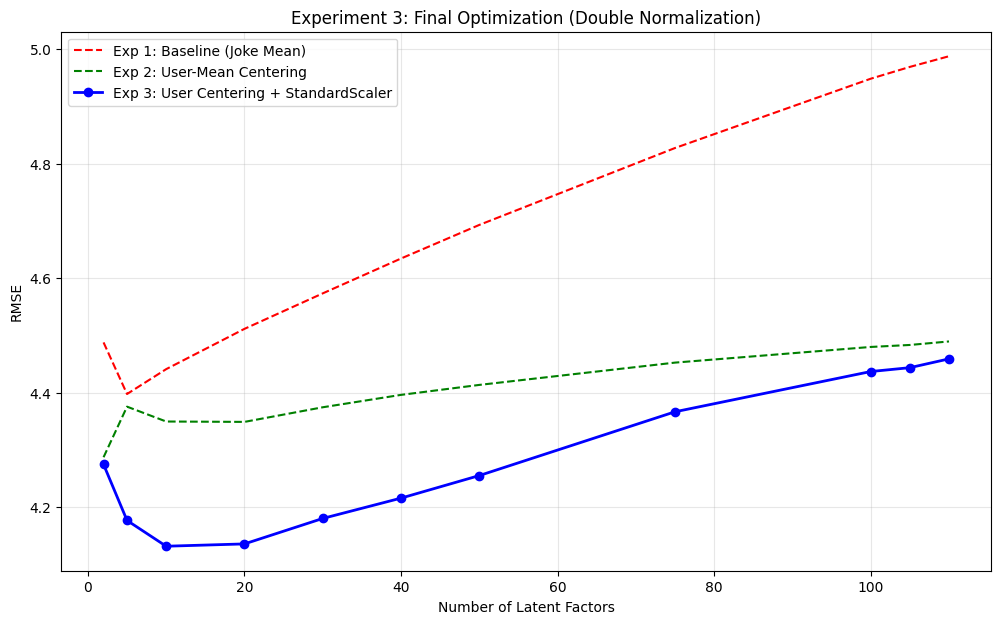

In [42]:
train_rmse_exp3 = []
test_rmse_exp3 = []

user_means = np.nanmean(train_ratings, axis=1).reshape(-1, 1)

for n in components_list:
    pipe = create_svd_pipeline_scaling(n)

    user_features = pipe.fit_transform(train_ratings)
    vt = pipe.named_steps['svd'].components_
    
    predicted_scaled = np.dot(user_features, vt)

    predicted_centered = pipe.named_steps['scaler'].inverse_transform(predicted_scaled)
    predicted_final = predicted_centered + user_means
    
    train_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, train_idx)
    test_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, test_idx)
    
    train_rmse_exp3.append(train_rmse)
    test_rmse_exp3.append(test_rmse)
    
    print(f"Components: {n:3} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(components_list, test_rmse_results, 'r--', label='Exp 1: Baseline (Joke Mean)')
plt.plot(components_list, test_rmse_centered, 'g--', label='Exp 2: User-Mean Centering')
plt.plot(components_list, test_rmse_exp3, 'bo-', label='Exp 3: User Centering + StandardScaler', linewidth=2)

plt.title('Experiment 3: Final Optimization (Double Normalization)')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Test with Robust Scaling**

In [44]:
def create_svd_pipeline_robust(n_components):
    return Pipeline([
        ('user_centering', FunctionTransformer(center_user_ratings)),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True)),
        ('scaler', RobustScaler()),
        ('svd', TruncatedSVD(n_components=n_components, random_state=42))
    ])

Robust SVD - Components:   2 | Train RMSE: 4.1672 | Test RMSE: 4.4040
Robust SVD - Components:   5 | Train RMSE: 3.9804 | Test RMSE: 4.3013
Robust SVD - Components:  10 | Train RMSE: 3.7648 | Test RMSE: 4.2476
Robust SVD - Components:  20 | Train RMSE: 3.5003 | Test RMSE: 4.2510
Robust SVD - Components:  30 | Train RMSE: 3.2895 | Test RMSE: 4.2705
Robust SVD - Components:  40 | Train RMSE: 3.0431 | Test RMSE: 4.2488
Robust SVD - Components:  50 | Train RMSE: 2.8627 | Test RMSE: 4.2603
Robust SVD - Components:  75 | Train RMSE: 2.4803 | Test RMSE: 4.2836
Robust SVD - Components: 100 | Train RMSE: 2.1793 | Test RMSE: 4.3138
Robust SVD - Components: 105 | Train RMSE: 2.1295 | Test RMSE: 4.3175
Robust SVD - Components: 110 | Train RMSE: 2.0732 | Test RMSE: 4.3287


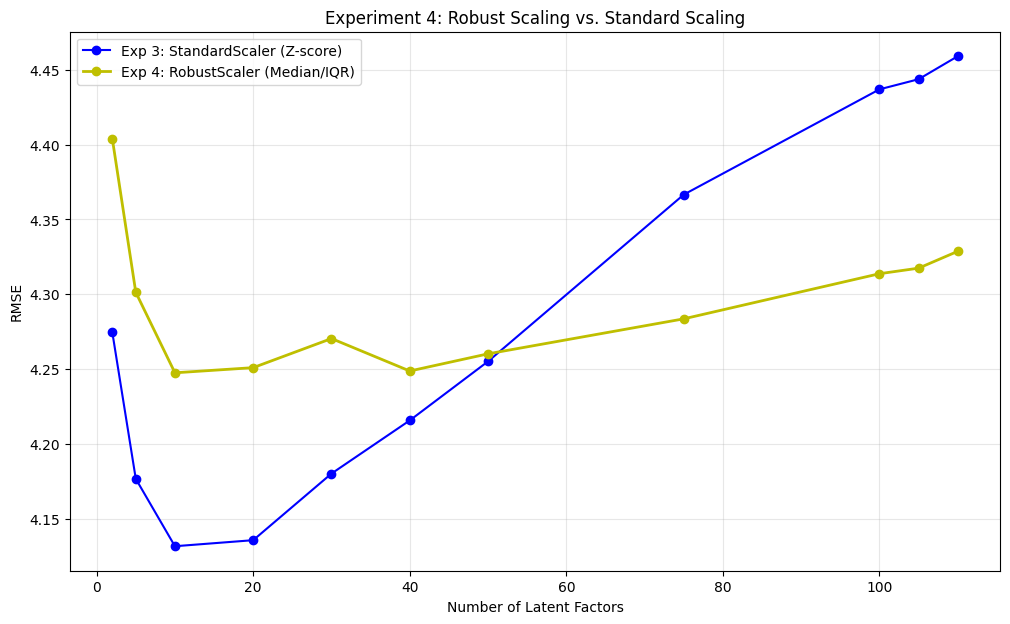

In [47]:
train_rmse_robust = []
test_rmse_robust = []

for n in components_list:
    pipe = create_svd_pipeline_robust(n)
    user_features = pipe.fit_transform(train_ratings)
    vt = pipe.named_steps['svd'].components_
    
    predicted_scaled = np.dot(user_features, vt)
    
    predicted_centered = pipe.named_steps['scaler'].inverse_transform(predicted_scaled)
    predicted_final = predicted_centered + user_means

    train_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, train_idx)
    test_rmse = calculate_rmse_at_indices(predicted_final, ratings_raw, test_idx)
    
    train_rmse_robust.append(train_rmse)
    test_rmse_robust.append(test_rmse)
    
    print(f"Robust SVD - Components: {n:3} | Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")

plt.figure(figsize=(12, 7))
plt.plot(components_list, test_rmse_exp3, 'bo-', label='Exp 3: StandardScaler (Z-score)')
plt.plot(components_list, test_rmse_robust, 'yo-', label='Exp 4: RobustScaler (Median/IQR)', linewidth=2)

plt.title('Experiment 4: Robust Scaling vs. Standard Scaling')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<summary>
StandardScaler achieved the global minimum RMSE of 4.13 at n=10 latent factors. This suggests that in low-dimensional spaces accounting for the extreme ratings provides valuable signal for the SVD algorithm. However, this model is prone to overfitting. This is shown by the sharp increase in error as complexity grows.
RobustScaler produced a significantly flatter error curve. While its minimum RMSE is higher than that of the Standard model it demonstrates  better  eneralization capabilities. At approximately n=50 the Robust model begins to outperform the Standard model. <br/>
We will go with the model of experiment 3
</summary>

**Models Export**

In [61]:
item_similarity_matrix = cosine_similarity(lsa_matrix_final)
joblib.dump(item_similarity_matrix, '../models/item_similarity.pkl')



['../models/item_similarity.pkl']

In [64]:
final_pipe = create_svd_pipeline_scaling(n_components=10)

final_user_features = final_pipe.fit_transform(ratings_raw)
final_vt = final_pipe.named_steps['svd'].components_

joblib.dump(final_pipe, '../models/svd_final.pkl')
joblib.dump(final_user_features, '../models/user_features.pkl')

['../models/user_features.pkl']